# Notebook 009: Initial EDA for Crime Incident Reports

This notebooks contains preliminary EDA for Boston crime incident report records.

Note that this is not a complete EDA, but has just been created to begin to understand the structure of this dataset and how other datasets might be used to enrich it with additional features

In [1]:
import urllib
import os
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')

readfile_crime = os.path.join(READDIR_ROOT, 'crime/crime-incidents.csv')

readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_sam, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/crime/crime-incidents.csv
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [4]:
# read in SAM address data and related shapefiles
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)

In [5]:
# check info of crime dataframe
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436666 entries, 0 to 436665
Data columns (total 17 columns):
INCIDENT_NUMBER        436666 non-null object
OFFENSE_CODE           436666 non-null object
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    436666 non-null object
DISTRICT               434440 non-null object
REPORTING_AREA         436666 non-null object
SHOOTING               11573 non-null object
OCCURRED_ON_DATE       436666 non-null object
YEAR                   436666 non-null object
MONTH                  436666 non-null object
DAY_OF_WEEK            436666 non-null object
HOUR                   436666 non-null object
UCR_PART               426730 non-null object
STREET                 423236 non-null object
Lat                    399636 non-null object
Long                   399636 non-null object
Location               436666 non-null object
dtypes: object(17)
memory usage: 56.6+ MB


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,NaN,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192082859,00724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.25951765,-71.12156299,"(42.25951765, -71.12156299)"
4,I192082751,00724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.26209214,-71.11670964,"(42.26209214, -71.11670964)"


In [10]:
# change datatypes for crime data columns as needed
df_crime['MONTH'] = df_crime['MONTH'].astype(int)

In [6]:
## Identify invalid or missing location data
df_crime.loc[(df_crime['Lat'].astype(float)<42) | (df_crime['Lat'].isnull())]['Lat'].value_counts(dropna=False)

NaN    37030
-1       927
Name: Lat, dtype: int64

In [17]:
# count records per calendar year
crime_count_year = df_crime['YEAR'].value_counts(dropna=False).sort_index()

# identify minimum and maximum month with records for each given year
min_max_months_year = {
    year: (min(month_set), max(month_set))
    for year, month_set in zip(
        crime_count_year.index,
        [
            set(df_crime.loc[df_crime['YEAR']==year]['MONTH'].values)
            for year in crime_count_year.index
        ]
    )
}

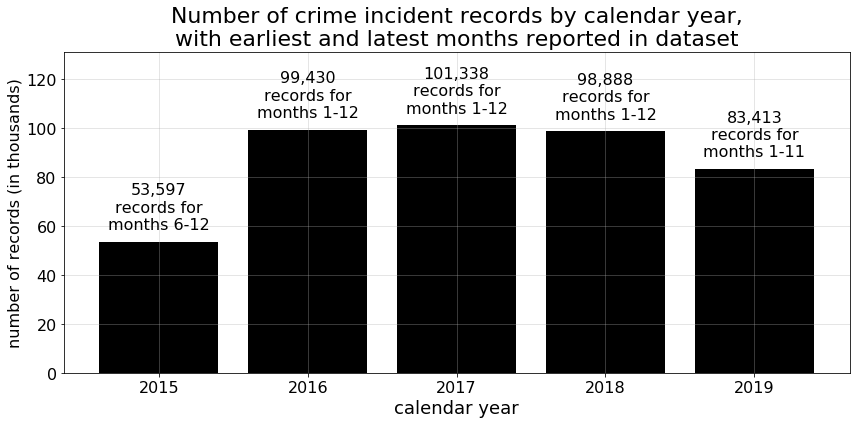

In [58]:
# print summary of years for all data records to identify partial years

savefig = True
scale = 1000
text_offset = 5
yscale_offset = 30

fig, ax = plt.subplots(figsize=(12, 6))

plt.title(
    "Number of crime incident records by calendar year,\n"\
    "with earliest and latest months reported in dataset",
    fontsize=22,
)

plt.bar(crime_count_year.index, crime_count_year.values/scale, color='k')

for (i, (year, values)), count in zip(enumerate(min_max_months_year.items()), crime_count_year.values/scale):
    ax.text(
        i, count+text_offset,
        '{0:,}\nrecords for\nmonths {1}-{2}'.format(int(count*scale), values[0], values[1]),
        color='k',
        fontsize=16,
        horizontalalignment='center'
    ) 

ax.tick_params(labelsize=16)
ax.set_ylabel("number of records (in thousands)", fontsize=16)
ax.set_ylim(bottom=0, top=max(crime_count_year.values/scale)+yscale_offset)
ax.set_xlabel("calendar year", fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-by-year.png'))
plt.show();

In [11]:
df_crime.groupby(['YEAR', 'MONTH']).agg({'INCIDENT_NUMBER': 'count'}).sort_index(level=['YEAR', 'MONTH'])

INCIDENT_NUMBER
YEAR MONTH                 
2015 6                 4200
     7                 8369
     8                 8395
     9                 8433
     10                8340
     11                7838
     12                8022
2016 1                 7865
     2                 7339
     3                 8215
     4                 8119
     5                 8594
     6                 8598
     7                 8650
     8                 8967
     9                 8553
     10                8606
     11                7945
     12                7979
2017 1                 8024
     2                 7429
     3                 8194
     4                 8101
     5                 8745
     6                 9016
     7                 9109
     8                 9251
     9                 8984
     10                8899
     11                7983
     12                7603
2018 1                 7860
     2                 6997
     3                 7849
     4                 8004
     5                 9072
     6                 9026
     7                 8789
     8                 8871
     9                 8566
     10                8441
     11                7694
     12                7719
2019 1                 7800
     2                 6930
     3                 7835
     4                 7643
     5                 8687
     6                 8453
     7                 8936
     8                 9248
     9                 8544
     10                8154
     11                1183

In [12]:
df_crime['OFFENSE_DESCRIPTION'].value_counts(dropna=False)

SICK/INJURED/MEDICAL - PERSON                      26720
INVESTIGATE PERSON                                 25532
M/V - LEAVING SCENE - PROPERTY DAMAGE              22207
VANDALISM                                          20125
ASSAULT SIMPLE - BATTERY                           19888
VERBAL DISPUTE                                     18575
INVESTIGATE PROPERTY                               15524
TOWED MOTOR VEHICLE                                15268
THREATS TO DO BODILY HARM                          12462
PROPERTY - LOST                                    12234
LARCENY THEFT FROM BUILDING                        12182
LARCENY THEFT FROM MV - NON-ACCESSORY              11600
WARRANT ARREST                                     11038
LARCENY SHOPLIFTING                                10890
M/V ACCIDENT - PROPERTY  DAMAGE                     8903
LARCENY ALL OTHERS                                  8379
M/V ACCIDENT - PERSONAL INJURY                      6794
ASSAULT - AGGRAVATED - BATTERY 